# Train Models with Varying Input Windows

In [49]:
import tensorflow as tf
import os
cwd = os.getcwd()
os.chdir('../../src/')
from dataloader import OneHotEncoder, load_fasta_data, RNASeqDataGenerator
os.chdir('../experiments/VariableInputWindow/')

In [50]:
from tqdm import tqdm
be_type='ABE'
sample='243C'
be_class='miniABEmax'
flank = 50
inpl = 2*flank+1

data_dir = "../../data/processed/{0}/{0}-sequence/".format(be_type)

train_chr = [str(x) for x in range(1, 20)]
test_chr = [str(x) for x in range(20, 23)] +['X']

train_seqs, train_ers, test_seqs, test_ers = [], [], [], []
for rep in tqdm(train_chr):
        seq, er = load_fasta_data(sample, rep, data_dir)
        train_seqs = seq+train_seqs
        train_ers = er+train_ers
for rep in tqdm(test_chr):
        seq, er = load_fasta_data(sample, rep, data_dir)
        test_seqs = seq+test_seqs
        test_ers = er+test_ers

100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


In [51]:
train_seqs2 = [x[(500)-flank:(500)+flank+1] for x in tqdm(train_seqs)]
test_seqs2 = [x[(500)-flank:(500)+flank+1] for x in tqdm(test_seqs)]

100%|██████████| 345719/345719 [00:00<00:00, 1274133.52it/s]


In [52]:
traingen = RNASeqDataGenerator(train_seqs2, train_ers, batch_size=1024, logits=False)
testgen = RNASeqDataGenerator(test_seqs2, test_ers, logits=False)

In [53]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7



In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, BatchNormalization, MaxPooling1D, Dropout
#create model
model = Sequential()
#add model layers
model.add(Conv1D(32, kernel_size=32, activation='relu', input_shape=(inpl,4)))
model.add(BatchNormalization())
model.add(Conv1D(32, kernel_size=32, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D())
model.add(Conv1D(32, kernel_size=16, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(16, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer="RMSprop", loss="mse", metrics=["mae", 'mse'])
print('Model built!')
print(model.summary())

Model built!
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 70, 32)            4128      
_________________________________________________________________
batch_normalization_3 (Batch (None, 70, 32)            128       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 39, 32)            32800     
_________________________________________________________________
batch_normalization_4 (Batch (None, 39, 32)            128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 19, 32)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 4, 32)             16416     
_________________________________________________________________
batch_normalization_5 (Batch (None, 4, 32

In [55]:
print('Training model')
history = model.fit(traingen, validation_data=testgen, workers=40, use_multiprocessing=True, epochs=2)
print('Model trained!')

Training model
Epoch 1/2
3269/3269 [==============================] - 131s 40ms/step - loss: 4.2141e-04 - mean_absolute_error: 0.0069 - mean_squared_error: 4.2141e-04 - val_loss: 2.1206e-04 - val_mean_absolute_error: 0.0066 - val_mean_squared_error: 2.1206e-04
Epoch 2/2
3269/3269 [==============================] - 127s 39ms/step - loss: 2.0361e-04 - mean_absolute_error: 0.0061 - mean_squared_error: 2.0361e-04 - val_loss: 2.1519e-04 - val_mean_absolute_error: 0.0061 - val_mean_squared_error: 2.1519e-04
Model trained!
Epoch 1/2


In [56]:
model.save("{}/{}CNN-{}.h5".format(be_class, sample, inpl))

# Model Performance Metrics

In [58]:
be_class = 'miniABEmax'
sample = '243C'
from scipy import stats
from tqdm import tqdm
import numpy as np

def rmse(x, y):
    return np.sqrt(np.mean((x-y)**2))

def spearman(x, y):
        return stats.spearmanr(x, y)[0]
def pearson(x, y):
        return stats.pearsonr(x, y)[0]

true_edit = np.array([])
for seq, er in tqdm(testgen):
    true_edit = np.hstack([true_edit, er])
    
r = []
s = []
p = []
 
for length in [101, 201, 501, 1001]: 
    model = tf.keras.models.load_model("{}/{}CNN-{}.h5".format(be_class, sample, length))
    flank = length//2
    test_seqs2 = [x[(500)-flank:(500)+flank+1] for x in tqdm(test_seqs)]
    testgen = RNASeqDataGenerator(test_seqs2, test_ers, logits=False)
    preds = model.predict(testgen)
    preds = np.squeeze(preds, axis=1)
    r.append(rmse(preds, true_edit))
    s.append(spearman(preds, true_edit))
    p.append(pearson(preds, true_edit))

100%|██████████| 345719/345719 [00:00<00:00, 1712392.55it/s]


In [59]:
r

[0.014669326401889456,
 0.014456601090262141,
 0.014708227482989816,
 0.015167205458775364]

In [60]:
p

[0.35905339046692425,
 0.380630673519574,
 0.3779856889731877,
 0.3968026458853528]

In [61]:
s

[0.30593278410863667,
 0.3256755806763642,
 0.3202339781494575,
 0.3391523526908555]

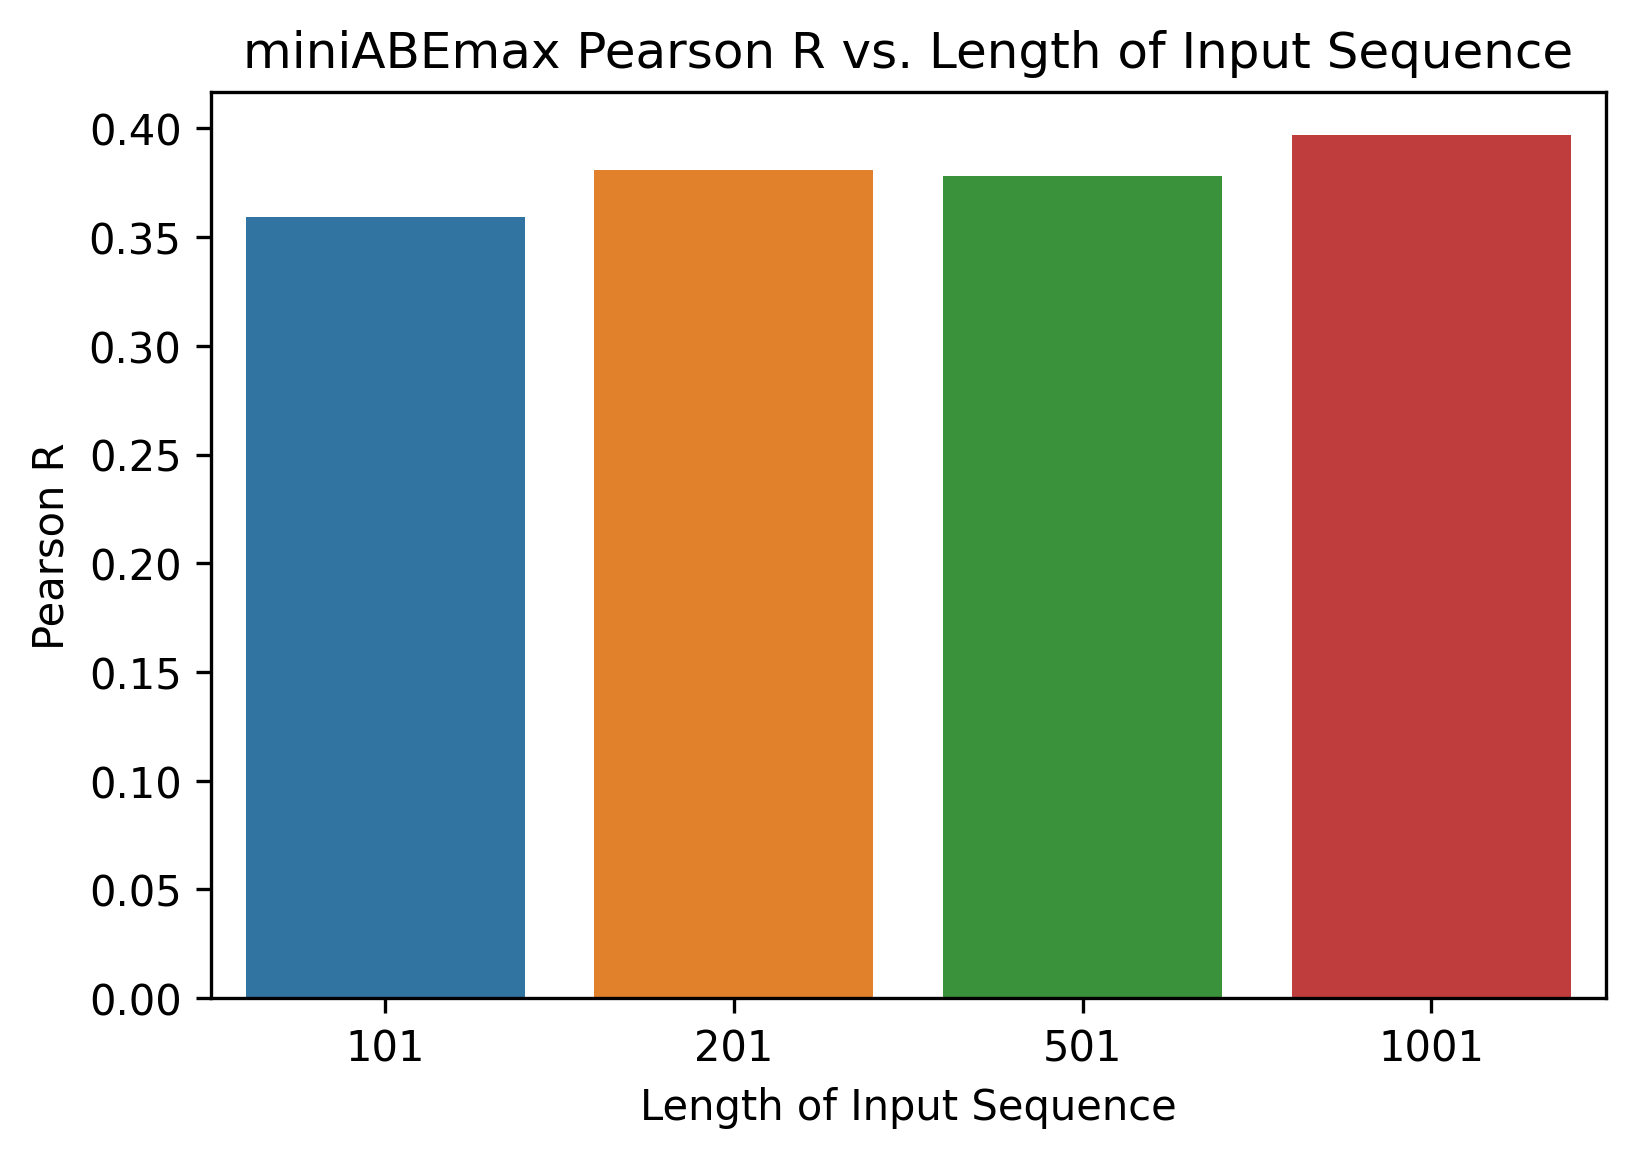

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
fig = sns.barplot([101, 201, 501, 1001], p)
fig.set_xlabel('Length of Input Sequence')
fig.set_ylabel('Pearson R')
fig.set_title('miniABEmax Pearson R vs. Length of Input Sequence')
plt.savefig("miniABEmax/miniABEmaxPearsonR.png")

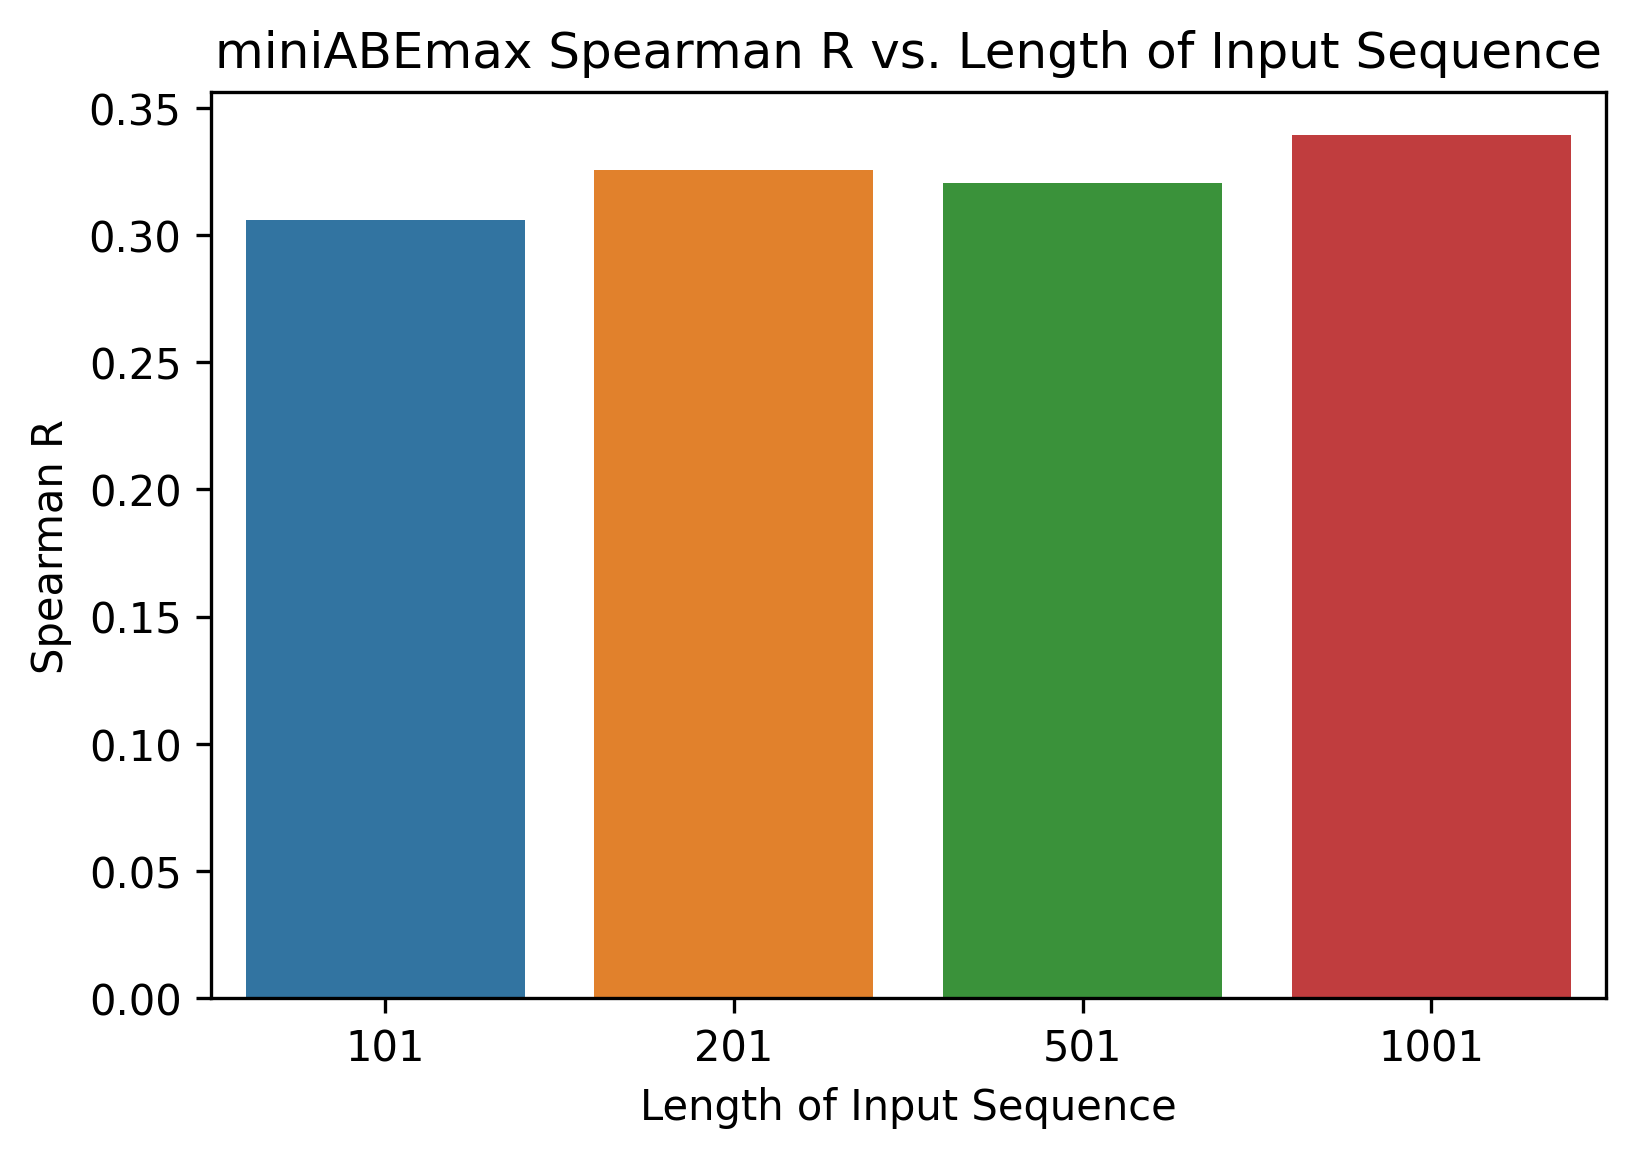

In [63]:
fig = sns.barplot([101, 201, 501, 1001], s)
fig.set_xlabel('Length of Input Sequence')
fig.set_ylabel('Spearman R')
fig.set_title('miniABEmax Spearman R vs. Length of Input Sequence')
plt.savefig("miniABEmax/miniABEmaxSpearmanR.png")

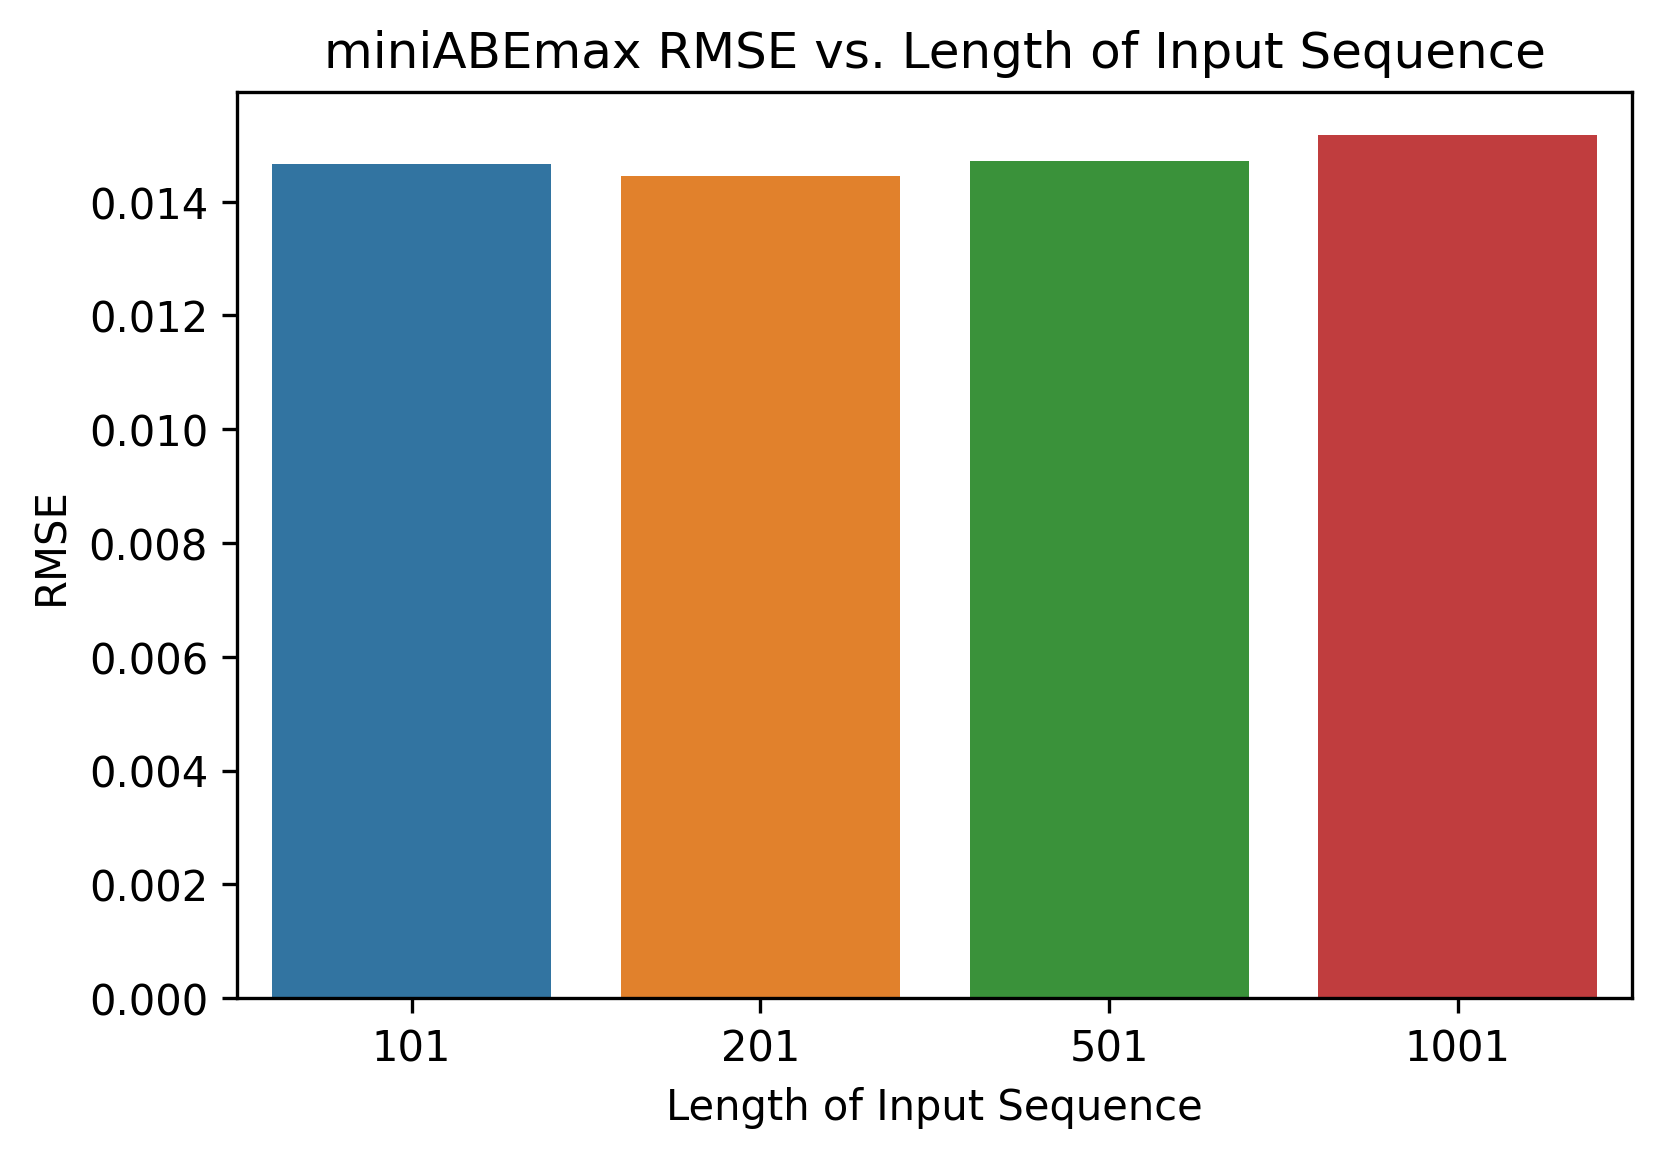

In [64]:
fig = sns.barplot([101, 201, 501, 1001], r)
fig.set_xlabel('Length of Input Sequence')
fig.set_ylabel('RMSE')
fig.set_title('miniABEmax RMSE vs. Length of Input Sequence')
plt.savefig("miniABEmax/miniABEmaxRMSE.png")

In [66]:
r, s, p

([0.014669326401889456,
  0.014456601090262141,
  0.014708227482989816,
  0.015167205458775364],
 [0.30593278410863667,
  0.3256755806763642,
  0.3202339781494575,
  0.3391523526908555],
 [0.35905339046692425,
  0.380630673519574,
  0.3779856889731877,
  0.3968026458853528])

In [68]:
import pandas as pd

df = pd.DataFrame({'Input':[101, 201, 501, 1001], 'RMSE':r, 'SpearmanR':s, 'PearsonR':p})

In [70]:
df.to_csv("miniABEmax/results.csv")